# MNIST Digit Recogniser

In [1]:
# Importing the Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

#### Tensorflow GPU takes up all the available RAM in the GPU if not limited. This prevents us from initializing Convolutional Layers.

In [2]:
# Limiting memory growth
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
train = pd.read_csv(r'...\train.csv')
test = pd.read_csv(r'...\test.csv')
y_train = train["label"].values;
X_train = train.drop(labels = ["label"],axis = 1).values 
X_test = test.values

#### Reshaping the Data to fit the Input Convolutional layer. The last 1 layer stands for 1 chromatic channel since pictures are in monochrome

In [4]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

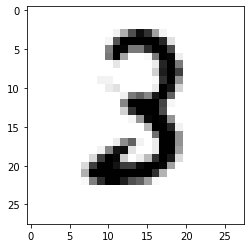

In [5]:
plt.imshow(X_test[4,:,:,0], plt.cm.binary)

#### Normalizing the Data allows Optimization Algorithms to optimize faster thus improving efficiency

In [6]:
#Normalizing the Data
X_train = X_train/255.0
X_test = X_test/255.0

In [7]:
# Convert label to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = to_categorical(y_train, num_classes = 10)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=2)

#### Creating the Model

In [10]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(10, activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        3

In [11]:
optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

#### Epochs can be increased to converge closer to the minimum. Kept at 5 to run faster

In [14]:
epochs = 5
batch_size = 128

#### Data Augmentation to generate additional data points

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

In [16]:
history = model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/5
295/295 [==============================] - 38s 129ms/step - loss: 0.2717 - accuracy: 0.9148 - val_loss: 2.7985 - val_accuracy: 0.3598 - lr: 0.0010
Epoch 2/5
295/295 [==============================] - 34s 115ms/step - loss: 0.0827 - accuracy: 0.9738 - val_loss: 0.0559 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 3/5
295/295 [==============================] - 67s 228ms/step - loss: 0.0640 - accuracy: 0.9807 - val_loss: 0.0485 - val_accuracy: 0.9852 - lr: 0.0010
Epoch 4/5
295/295 [==============================] - 103s 350ms/step - loss: 0.0496 - accuracy: 0.9845 - val_loss: 0.0405 - val_accuracy: 0.9898 - lr: 0.0010
Epoch 5/5
295/295 [==============================] - 107s 363ms/step - loss: 0.0443 - accuracy: 0.9868 - val_loss: 0.0828 - val_accuracy: 0.9736 - lr: 0.0010


#### The following graph is plooted for 5 epochs. with more epochs it becomes more realistic

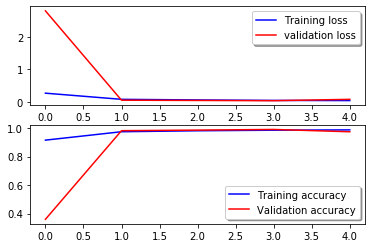

In [19]:
# Draw the loss and accuracy curves of the training set and the validation set.
# Can judge whether it is under-fitting or over-fitting
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [22]:
results = model.predict(X_test) 
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
results = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
results.to_csv(r"...\submission.csv", index = False)